In [1]:
import argparse
import sys

import cv2
import numpy as np
import yaml
import PIL
import dlib

import torch
import torchvision.transforms.functional as F

from imutils import face_utils
from utils import (get_mask, get_preinference_transforms, extend_bbox_by_landmarks, 
                   restore_normalized_img, extend_bbox)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Load experiment config from the predefined path.
The config containes path to the image to be manipulated, path to the facial landmark detector checkpoint, as well as some extra data.

In [ ]:
cfg_path = 'configs/face_manipulation_cfg.yaml'

with open(cfg_path, 'r') as f:
    cfg = yaml.safe_load(f)
    
img_path = cfg['img_path']
facial_landmarks_model_path = cfg['facial_landmarks_model_path']
face_attribute = cfg['face_attribute']

for k, v in cfg.items():
    print(k,':' , v)

#### Initialize both face and facial landmarks detector.

In [3]:
face_detector = dlib.get_frontal_face_detector()
landmarks_predictor = dlib.shape_predictor(facial_landmarks_model_path)

#### Load image and convert it to a grayscale, as both facial detectors operate over single-channel images

In [5]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#### Run both detectors, remaining afterwards a single face with the corresponding landmarks if more detected.

As both detectors run independently, facial landmarks coordinates and facial bounding box, are incoherent: facial bounding box might be narrower, than the facial landmarks range. Therefore, we extend facial bouding box, to comprise all facial landmarks.

In [6]:
detected_face = face_detector(grayscale_img, 1)
num_faces_detected = len(detected_face)

if num_faces_detected >= 1:
    detected_face = detected_face[0]

facial_landmarks = landmarks_predictor(grayscale_img, detected_face)
facial_landmarks = face_utils.shape_to_np(facial_landmarks)
face_bbox = extend_bbox_by_landmarks(detected_face, facial_landmarks)

#### Let us display facial bounding box as well the keypoints detected

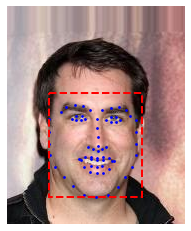

In [7]:
fig, ax = plt.subplots(1)

ax.imshow(img)
ax.axis('off')

for point in facial_landmarks:
    ax.scatter(*point, s=3, c='b')

x_min, y_min, x_max, y_max = face_bbox
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=2, edgecolor='r', facecolor='none', linestyle='--')

ax.add_patch(rect)

plt.show()

#### In an attempt to modify a single facial attribute, it seems excessive to operate over the entire detected face.
Therefore, one requires to derive a mask of the region, upon which the modification will take place. Based on the provided information, which facial attribute is desired to be changed, we select a subset of keypoints and create a heatmap of the relevant region.

In [8]:
face_attribute_mask = get_mask(face_attribute, facial_landmarks, img.shape[:2])

(-0.5, 177.5, 217.5, -0.5)

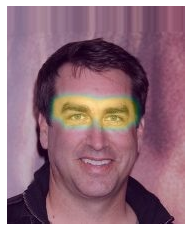

In [9]:
plt.imshow(img)
plt.imshow(face_attribute_mask, alpha=0.3)
plt.axis('off')

#### The basic solution to manipulate facial attributes is AutoEncoder. 
Each image is encoded into a fixed-size vector representation, know as latent vector, which is further decoded, to resemble the initial image as much as possible. As the latent-vector space is much smaller, than the image space, information is lost during the encoding-decoding process of an imagem, making the restored image  just slightly similiar to the original. However, the key component is that well-trained autoencoder, comprises in a latent-vector space general information about the face: hair color, whether eyes are closed or not, is the person smiling etc. Moreover, autoencoders support vector arithmetic, meaning that  having a latent vector for a face, one can change its appearance, adding or subtracting the precomputed mean latent vector for a particular facial atttribute. For our purposes we will utilize VAE, which instead of the direct latent vector retrieval, learns to retrieve the distribution. But generally, the idea is the same.

For the demo I selected this repo https://github.com/AntixK/PyTorch-VAE

The **pros** of this repo are:

* Written in Pytorch Lightning, which is a highly convinient tool to grasp the entire pipeline of model building, training, validation and logging, especially when the desire to clone other repo to quickly check the idea, as in our case
* The author concerned about the reproducibility, setting the required random seeds fixed
* The author provide images of the restored and generated images, signifying about the reasonable quality of the potentially trained VAE.
* Several hundred stars, signifying that some other people possible used it with a positive experience without coming across severe bugs.

The **cons** of this repo are:
* No pretrained weights provided

To train the model, Celeba dataset http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html is used.

The repo by default trains VAE on 64x64 image resolution. I've tried to retrain, changing the resolution to a finer one 128x128, adjusting the dimension of the latent space. However, several experiments depicted , that the encoding power on a 64x64 is much better: for 128x128 resolution the model failed to encode all the relevant facial attribute, for instance, constantly failing to decode eyeglasses, which is not the case for the images with a 64x64 resolution.

An example of a trained VAE on 64x64 reconstuction power on a validation dataset:

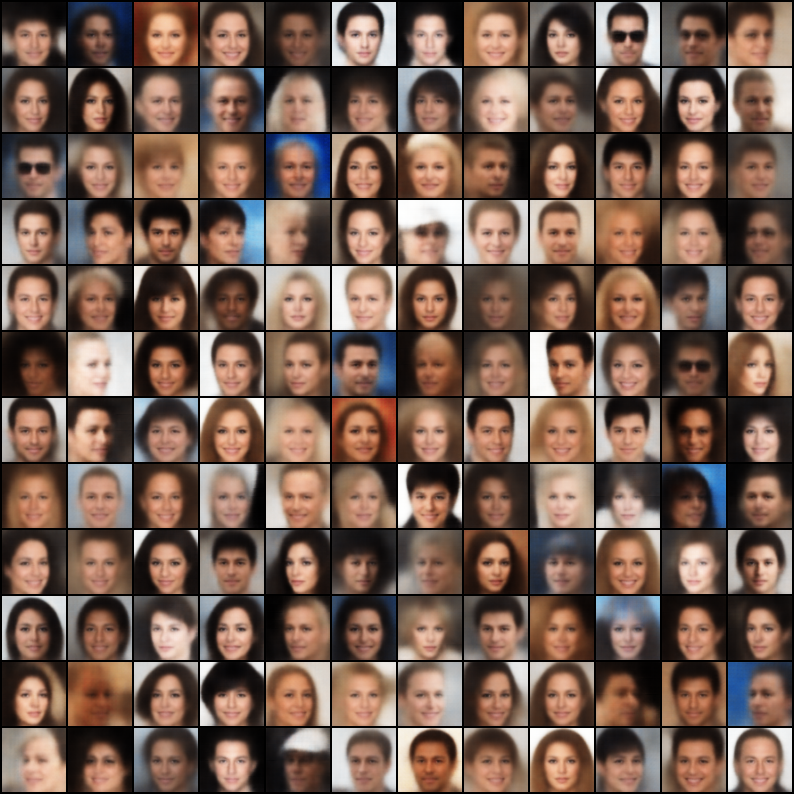

In [9]:
recon_vae = PIL.Image.open('imgs/recon_vae.png')
recon_vae

In [10]:
sys.path.append('PyTorch-VAE/') # dirty hack to make repo accessible

from models.vanilla_vae import VanillaVAE

Initialize VAE model and load the trained weights

In [11]:
with open(cfg['vae_cfg_path'], 'r') as f:
    vae_cfg = yaml.safe_load(f)
    
model = VanillaVAE(**vae_cfg['model_params'])

state_dict = torch.load(cfg['vae_model_path'], map_location=torch.device('cpu'))['state_dict']
model.load_state_dict(state_dict)
model.eval()

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

Face detector provides bounding box tightly to the face borders, omitting, for instance, hair or ears, which is not the case for most of the images in training set. To fix the issue, one can extend bounding box vertically and horizontally for some proportion of the image shape and crop. 

Further, the image is transformed and forward path is called.

In [33]:
face_bbox_extended = extend_bbox(face_bbox, img.shape[:2], 0.25, 0.2)
cropped_by_face_img = F.crop(PIL.Image.fromarray(img), 
                             face_bbox_extended[1], face_bbox_extended[0], 
                             face_bbox_extended[3] - face_bbox_extended[1], 
                             face_bbox_extended[2] - face_bbox_extended[0])

inference_transform = get_preinference_transforms(cfg)
transformed_face = inference_transform(cropped_by_face_img)

with torch.no_grad():
    restored, _, mu, _ = model.forward(transformed_face.unsqueeze(0))

restored = restore_normalized_img(restored[0].detach())

Here we depict the original image and the its restoration counterpart.

(-0.5, 63.5, 63.5, -0.5)

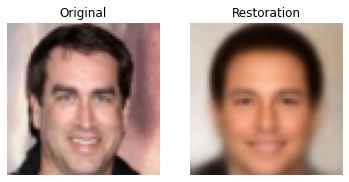

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(restore_normalized_img(transformed_face))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(restored)
plt.title('Restoration')
plt.axis('off')

To manipulate with the facial attributes, we use the vector arithmetics in latent space, using the precomputed vectors for a particular attribute. Using the trained model and labels of the Celeba dataset, one can compute the mean vector of peoples' latent representation, which do and do not have a particular facial attirubute over the entire dataset. 

In [18]:
vae_latent_vector = torch.load(cfg['latent_vector'][face_attribute])

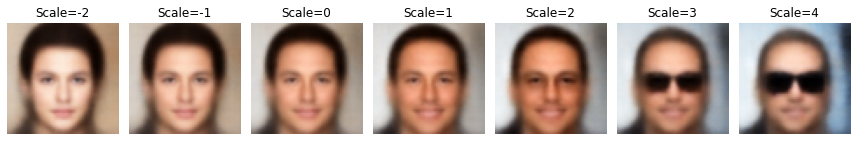

In [19]:
plt.figure(figsize=(12, 10))

for i, scale in enumerate(range(-2, 5, 1)):
    gen_img = restore_normalized_img(model.decode(mu - scale * vae_latent_vector).detach()[0])
    plt.subplot(1, len(range(-2, 5, 1)), i + 1)
    plt.imshow(gen_img)
    plt.axis('off')
    plt.title('Scale={}'.format(scale) )

plt.tight_layout()

In [20]:
scale = cfg['face_attribute_change_scale']
gen_img = restore_normalized_img(model.decode(mu - scale * vae_latent_vector).detach()[0])

gen_img = F.resize(PIL.Image.fromarray(gen_img), cropped_by_face_img.size[::-1])
gen_img = np.array(gen_img)

In [21]:
def combine_images(orig_img, gen_img, bbox, mask):
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, -1)

    x_min, y_min, x_max, y_max = bbox
    full_size_gen_img = np.zeros(orig_img.shape)
    full_size_gen_img[y_min : y_max, x_min : x_max] = gen_img
    inverse_mask = 1 - mask
    combined = orig_img * inverse_mask + full_size_gen_img * mask

    return combined.astype('uint8')

The last step is to combine original image with the generated one, using the mask heatmap for the provided face attribute.

(-0.5, 177.5, 217.5, -0.5)

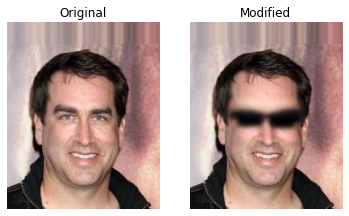

In [22]:
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Modified')
plt.imshow(combine_images(img, gen_img, face_bbox_extended, face_attribute_mask))
plt.axis('off')

The second possible variant of the task solution AttGAN. However, the model seems much more intricate and less lightweight. Cloned the repo from https://github.com/elvisyjlin/AttGAN-PyTorch and played around with several pretrained models on different images.

At a first glance, the model is less flexible to manipulate with images. Therefore, I merely post the result of AttGAN for the sake of comparison for the image used  earlier.

In [4]:
attgan_img = cv2.imread('imgs/attgan_glasses.jpg')
attgan_img = cv2.cvtColor(attgan_img, cv2.COLOR_BGR2RGB)

(-0.5, 127.5, 127.5, -0.5)

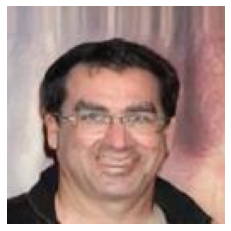

In [7]:
plt.imshow(attgan_img)
plt.axis('off')